In [51]:
import pandas as pd
from Environments import TrainingEnv
from Environments import TestingEnv

In [52]:
from stable_baselines3.common.env_checker import check_env

In [53]:
data = pd.read_csv('KO_Data.csv')
data.drop(labels=['Date'], axis=1, inplace=True)
data.dropna(inplace=True)
data['Close'] = data['Close'].replace(to_replace=0.0, method='ffill')
data

C:\Users\joeya\AppData\Local\Temp\ipykernel_22428\3906304662.py:4: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Close'] = data['Close'].replace(to_replace=0.0, method='ffill')


,Close,Volume,SMA Ratio,RSI,Bandwidth,Pct Change
0,0.033748,0.082265,0.808793,0.614203,0.076375,0.354850
1,0.033389,0.051950,0.803937,0.680861,0.066035,0.380485
2,0.035095,0.066910,0.794504,0.672312,0.058724,0.403359
3,0.030156,0.055416,0.776058,0.518389,0.057444,0.329992
4,0.027822,0.041849,0.757639,0.516280,0.061770,0.358389
...,...,...,...,...,...,...
4937,1.647322,0.123954,0.504167,0.484024,0.112769,0.426581
4938,1.660064,0.112748,0.506113,0.524323,0.095913,0.412517
4939,1.651242,0.108860,0.508709,0.513591,0.089977,0.365161
4940,1.666926,0.079137,0.512056,0.516198,0.088632,0.418924


In [54]:
training_data = data.iloc[:int(0.7 * len(data)), :].copy(deep=True)
validation_data = data.iloc[int(0.7 * len(data)):int(0.8 * len(data)), :].copy(deep=True)
testing_data = data.iloc[int(0.8 * len(data)):, :].copy(deep=True)

In [55]:
training_data

,Close,Volume,SMA Ratio,RSI,Bandwidth,Pct Change
0,0.033748,0.082265,0.808793,0.614203,0.076375,0.354850
1,0.033389,0.051950,0.803937,0.680861,0.066035,0.380485
2,0.035095,0.066910,0.794504,0.672312,0.058724,0.403359
3,0.030156,0.055416,0.776058,0.518389,0.057444,0.329992
4,0.027822,0.041849,0.757639,0.516280,0.061770,0.358389
...,...,...,...,...,...,...
3454,0.856249,0.201924,0.595954,0.020070,0.359532,0.411171
3455,0.876862,0.166084,0.568186,0.057075,0.375618,0.459196
3456,0.861131,0.179348,0.534328,0.053129,0.399120,0.328374
3457,0.851909,0.171475,0.497376,0.041752,0.425222,0.351160


In [56]:
validation_data

,Close,Volume,SMA Ratio,RSI,Bandwidth,Pct Change
3459,0.851909,0.122397,0.417487,0.061153,0.472526,0.409269
3460,0.862758,0.161238,0.380047,0.086943,0.484329,0.423936
3461,0.863844,0.109722,0.383648,0.082729,0.492371,0.388375
3462,0.871167,0.107099,0.393035,0.099389,0.490994,0.410848
3463,0.869811,0.083072,0.405393,0.160609,0.479965,0.379604
...,...,...,...,...,...,...
3948,1.051350,0.145256,0.342789,0.369132,0.141767,0.406286
3949,1.069871,0.080428,0.358294,0.396674,0.138500,0.442375
3950,1.077685,0.122444,0.374118,0.338527,0.109641,0.408579
3951,1.071318,0.095703,0.383008,0.402047,0.100712,0.364917


In [57]:
testing_data

,Close,Volume,SMA Ratio,RSI,Bandwidth,Pct Change
3953,1.088682,0.156242,0.411033,0.488299,0.095465,0.447051
3954,1.099968,0.083689,0.437352,0.496421,0.121093,0.418846
3955,1.087814,0.099834,0.457539,0.496497,0.130106,0.347716
3956,1.083762,0.080860,0.473405,0.583742,0.132218,0.372110
3957,1.102284,0.080470,0.497922,0.585529,0.145488,0.441081
...,...,...,...,...,...,...
4937,1.647322,0.123954,0.504167,0.484024,0.112769,0.426581
4938,1.660064,0.112748,0.506113,0.524323,0.095913,0.412517
4939,1.651242,0.108860,0.508709,0.513591,0.089977,0.365161
4940,1.666926,0.079137,0.512056,0.516198,0.088632,0.418924


In [58]:
training_env = TrainingEnv(training_data, episode_length=500)
check_env(training_env, warn=True)
validation_env = TestingEnv(validation_data)
check_env(validation_env, warn=True)
testing_env = TestingEnv(testing_data)
check_env(testing_env, warn=True)

In [59]:
# from stable_baselines3 import DQN
# from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
# eval_callback = EvalCallback(validation_env, eval_freq=100, callback_after_eval=stop_train_callback, verbose=1)

# model = DQN("MlpPolicy", training_env, buffer_size=5000, learning_rate=0.005, seed=6)
# model.learn(int(1e10), callback=eval_callback)

In [60]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    def __init__(self, env, eval_freq, verbose=0):
        super().__init__(verbose)
        self.env = env
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            obs, info = self.env.reset()
            rewards = []
            while True:
                action, _states = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.env.step(action)
                rewards.append(reward)
                if terminated or truncated:
                    break
            self.logger.record("Mean Validation Set Reward", np.array(rewards).mean())
            self.logger.record("Cumulative Validation Set Reward", np.array(rewards).sum())
        return True


In [61]:
from stable_baselines3 import DQN

# eval_callback = EvalCallback(training_env, eval_freq=500, verbose=0)

tensorboard_callback = TensorboardCallback(validation_env, 500)
model = DQN("MlpPolicy", training_env, buffer_size=5000, seed=6, exploration_fraction=0.5, tensorboard_log="./tensorboard", learning_rate=0.001)
# model.learn(500*1000, callback=eval_callback)
model.learn(500*10000, callback = tensorboard_callback)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_performance(env, data):
    portfolio_values = []
    budget = 10000
    budgets = []
    obs, info = env.reset()
    asset_allocations = []
    actions = []
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        percent_change = (data.iloc[env.cur_row_num, 0] - data.iloc[env.cur_row_num-1, 0]) / data.iloc[env.cur_row_num-1, 0]
        budget = budget * (1+percent_change)
        budgets.append(budget)
        portfolio_values.append(info['Portfolio Value'])
        asset_allocations.append(info['Asset Allocation'])
        actions.append(info['Action Taken'])
        if terminated or truncated:
            break
    plt.figure()
    plt.plot(np.array(asset_allocations))
    plt.figure()
    plt.hist(np.array(actions), bins=5)
    plt.figure()
    plt.plot(np.array(portfolio_values), "blue")
    plt.plot(np.array(budgets), "red")
    plt.show()

In [27]:
len(training_data)
training_data.head()

,Close,Volume,SMA Ratio,RSI,Bandwidth,Pct Change
0,0.033748,0.082265,0.808793,0.614203,0.076375,0.354850
1,0.033389,0.051950,0.803937,0.680861,0.066035,0.380485
2,0.035095,0.066910,0.794504,0.672312,0.058724,0.403359
3,0.030156,0.055416,0.776058,0.518389,0.057444,0.329992
4,0.027822,0.041849,0.757639,0.516280,0.061770,0.358389


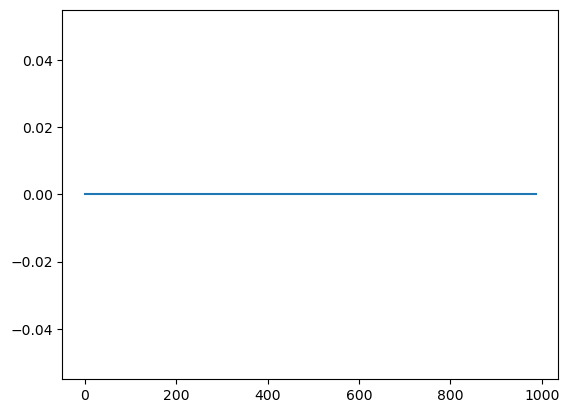

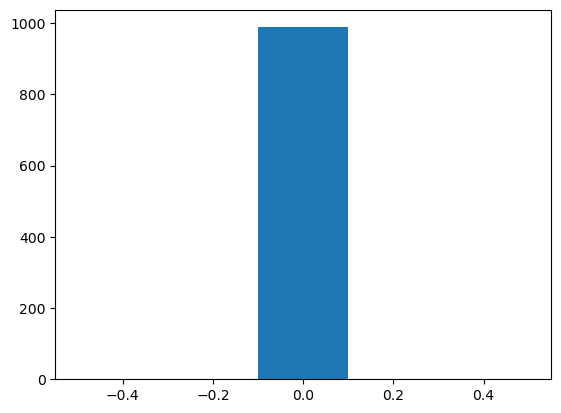

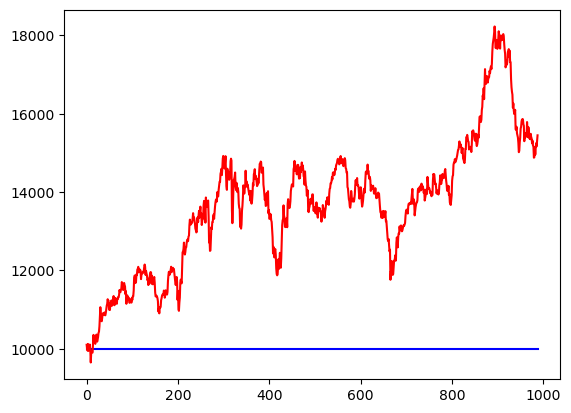

In [42]:
visualize_performance(testing_env, testing_data)

In [ ]:
# revisit features
# create new branch where the dataset is split into 10 periods and alternating periods are designated for training, the rest are for validation or testing
#        change training so that training episodes consist of one of the 5 training periods to better match validation/testing periods
# fix tests for the new branch and then see if it results in better validation/testing performance
# also think about using optuna for hyperparameter tuning

In [22]:
# from stable_baselines3 import DQN
# import optuna

# max_return = 0.0

# def objective(trial):
#     global max_return
#     learning_rate = trial.suggest_float('learning rate', 0.0001, 0.01)
#     gamma = trial.suggest_float('gamma', 0.95, 0.999)
#     exploration_fraction = trial.suggest_float('exploration fraction', 0.1, 0.3)
#     total_timesteps = trial.suggest_int('total_timesteps', 250 * 50, 250 * 1000)


#     model = DQN("MlpPolicy", training_env, learning_rate=learning_rate, 
#                 buffer_size=5000, gamma=gamma, exploration_fraction=exploration_fraction)
    

#     model.learn(total_timesteps=total_timesteps)

#     obs, info = validation_env.reset()
#     while True:
#         action, _states = model.predict(obs, deterministic=True)
#         obs, reward, terminated, truncated, info = validation_env.step(action)
#         if terminated or truncated:
#             break

#     raw_return = (validation_env.portfolio_value - validation_env.budget) / validation_env.budget
#     if raw_return > max_return:
#         model.save("RL_Agent")
#         max_return = raw_return
#     del model
#     return -raw_return

    


# study = optuna.create_study()
# study.optimize(objective, n_trials = 20, show_progress_bar=True)

# print(f'Best Parameters: {study.best_params}')
# print(f'Best value: {study.best_value}')